In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
# gtf = '/Users/fairliereese/Documents/programming/mele_lab/projects/240903_pt/data/transcripts_filt_with_gene.gtf'
# sg = swan.SwanGraph()
# sg.add_annotation(gtf)
# ab_file = '/Users/fairliereese/Documents/programming/mele_lab/projects/240903_pt/data/kallisto_quant/matrix.abundance.tsv'
# sg.add_abundance(ab_file)
# sg.save_graph('poder_sg')


In [6]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [7]:
sg = swan.read('poder_sg.p')

Read in graph from poder_sg.p


In [8]:
def get_melted_pi_counts_table(ver='poder', min_t_cpm=None):
    assemblies = ['same_population_sample', 'afr_sample', 'european_sample']
    meta = load_meta()
    meta = meta.loc[meta.merged_run_mode==True]
    sample_d = dict([(entry.cell_line_id, entry['sample']) \
                     for ind, entry in meta.iterrows()])
    
    
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]
    df = pd.read_csv(f, sep='\t')
    df.head()
    df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
    df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
    df.rename(sample_d, axis=1, inplace=True)

    
    id_vars = ['tid']
    sample_columns = list(set(df.columns)-set(id_vars))
    tpm_df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='t_tpm')
    tpm_df = tpm_df.merge(meta[['sample', 'population']],
                          how='left', on='sample')
    tpm_df.head()
    
    if ver == 'poder':
        f = '../data/analysis/04_relative_abundances_allgenes_pantrx.tsv'
    elif ver == 'v47':
        f = '../data/analysis/04_relative_abundances_allgenes_gencode.tsv'
    df = pd.read_csv(f, sep='\t')
    df.sort_values(by='geneid.v').head()
    df.rename({'geneid.v':'gid', 'transcriptid.v':'tid'}, axis=1, inplace=True)
    id_vars = ['tid', 'gid']
    sample_columns = list(set(df.columns)-set(id_vars))
    df = df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='pi')

    
    # filter based on min. cpm
    df = df.merge(tpm_df, how='left',
                  on=['tid', 'sample'])
    
    
    # add gene expression
    ver = 'poder'
    if ver == 'poder':
        f = expand(proc_cfg(config['lr']['kallisto']['quant']['gene_tsv'],od))[0]
    elif ver == 'v47':
        f = expand(proc_cfg(config['lr']['v47_kallisto']['quant']['gene_tsv'],od))[0]
    gene_df = pd.read_csv(f, sep='\t')
    gene_df.head()
    gene_df.sort_values(by='geneid.v').head()
    gene_df.rename({'geneid.v':'gid'}, axis=1, inplace=True)
    id_vars = ['gid']
    sample_columns = list(set(gene_df.columns)-set(id_vars))
    gene_df = gene_df.melt(id_vars=id_vars, value_vars=sample_columns, 
                      var_name='sample', value_name='g_counts')
    gene_df.head()
    
    # filter based on min. cpm
    df = df.merge(gene_df, how='left',
                  on=['gid', 'sample'])
    
    
    if min_t_cpm:
        df = df.loc[df.t_tpm >= min_t_cpm]
        
    return df

In [16]:
df = get_melted_pi_counts_table(ver='poder', min_t_cpm=None)
df['log_tpm'] = np.log(df.t_tpm+1)

In [27]:
gene = 'ENSG00000008517.19'
obs_cond = 'AJI5'
obs_col = 'sample'
max_t = 10

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_2912/1467340380.py:97: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


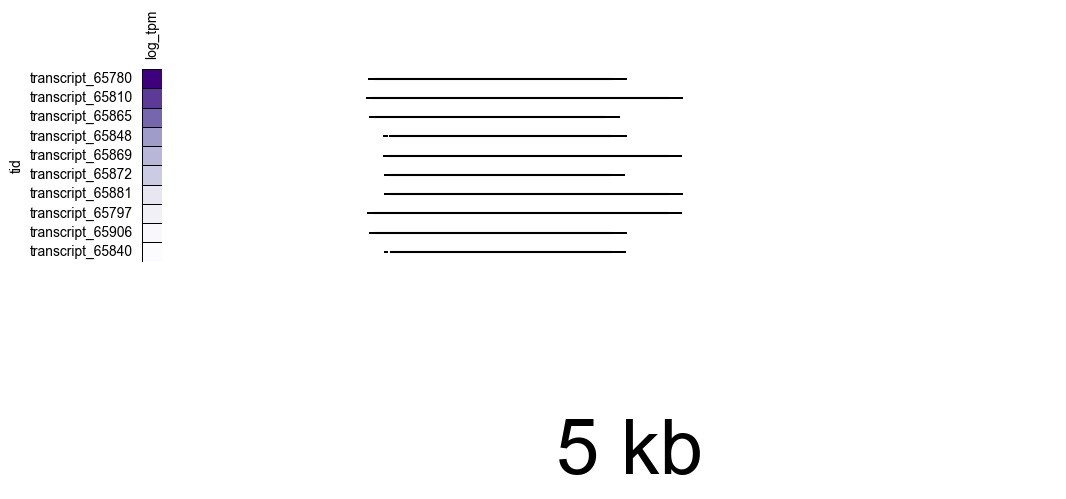

In [30]:
def add_exp_heatmap(df, ax):
    temp = df[['tid', 'log_tpm']]
    temp.set_index('tid', inplace=True)
    temp2 = pd.DataFrame()

    # https://stackoverflow.com/questions/50754471/seaborn-heatmap-not-displaying-all-xticks-and-yticks
    ax = sns.heatmap(temp, cbar=False, cmap='Purples',
                     linewidths=0.5, linecolor='k',
                      square=True,
                     fmt='', ax=ax, yticklabels=True)
    ax.tick_params(left=False,
                   right=False, labelright=False,
                   bottom=False, labelbottom=False,
                   labeltop=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    return ax

# def plot_browser_isos(sg, gene,
#                       df,
#                       obs_col,
#                       obs_conds,
#                       h=0.1, w=56, fig_w=14,
#                       light_shade=None,
#                       dark_shade=None):
#     """
#     Plot browser style isoform models for a given sample
#     """

h=0.1
w=56
fig_w=14
# subset and sort by exp
temp = df.loc[(df.gid==gene)&(df[obs_col]==obs_cond)].sort_values(by='t_tpm', ascending=False)
temp = temp.head(max_t)
tids = temp.tid.tolist()

# figure / subplot settings
fig_h = len(tids)/4
w1_rat = (fig_w/6)*2
w2_rat = (fig_w/6)*4
fig, (ax, ax2) = plt.subplots(1,2, figsize=(fig_w, fig_h),
                              gridspec_kw={'width_ratios':(w1_rat, w2_rat)},
                              frameon=False, sharey=True)
fig.subplots_adjust(wspace=0.00)
fig.subplots_adjust(hspace=0.00)

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

# first add the labels
ax = add_exp_heatmap(temp, ax)

# get y coords from heatmap
y_locs = ax.get_yticks()

# get x coords from heatmap
x = 0
i = 0

# get height of cdss
h_cds = h*2

linewidth = 1.5

for index, entry in temp.iterrows():

    y_ytick = y_locs[i]

    # y coords
    y = y_ytick-(h/2)
    y_cds = y_ytick-(h_cds/2)

    # tid
    tid = entry['tid']

    # plot models + cds
    color = 'k'
    ax2 = sg.plot_browser(tid, y=y, x=x, h=h, w=w, color=color,
                          ax=ax2, linewidth=linewidth)

    # print('TODO - also add this back in')
    # ax2 = plot_cds(entry, sg, x, y_cds, h_cds, ax2, color)

    i+=1

y_space=0.5

# add scale
y_ytick = (len(temp.index) + i)
y = y_ytick-(h_cds/2)
ax2 = sg.pg.plot_scale(x, y, h_cds, w, ax2, linewidth=linewidth)

# print(sg.pg.scale*(250000))

plt.tight_layout()
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_frame_on(False)

# return ax, tpm_df

In [ ]:
def plot_cds(entry, sg, x, y, h, ax, color):
        c_dict, order = get_sector_colors()

        def get_inc_region(entry, how, scale):
            inc = 80
            if how == 'start' and entry.Strand == '+':
                col = 'CDS_Start'
            elif how == 'stop' and entry.Strand == '+':
                col = 'CDS_Stop'
            elif how == 'start' and entry.Strand == '-':
                col = 'CDS_Stop'
            elif how == 'stop' and entry.Strand == '-':
                col = 'CDS_Start'
            if entry.Strand == '+':
                regions = (entry[col],entry[col]+inc)
            elif entry.Strand == '-':
                regions = (entry[col],entry[col]-inc)
            regions = [regions]
            # print(f'Scale: {scale}')
            # print(f'CDS inc: {inc}')

            return regions

        # get start and stop
        strand = entry.Strand
        if strand == '+':
            orf_start = entry['CDS_Start']
            orf_end = entry['CDS_Stop']
        elif strand == '-':
            orf_end = entry['CDS_Start']
            orf_start = entry['CDS_Stop']
        loc_path = sg.pg.loc_path
        exons = [(sg.pg.loc_df.loc[v1, 'coord'],
            sg.pg.loc_df.loc[v2, 'coord']) \
            for v1,v2 in zip(loc_path[:-1],loc_path[1:])][::2]
        cds = get_cds(exons, orf_start, orf_end, strand)
        ax = sg.pg.plot_regions(cds, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, color, ax)

        # start codon
        color = c_dict['tss']
        regions = get_inc_region(entry, 'start', sg.pg.scale)
        ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, color, ax)

        # stop codon
        color = c_dict['tes']
        regions = get_inc_region(entry, 'stop', sg.pg.scale)
        ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, color, ax)

        return ax

    # colormap definition
    if not light_shade:
        light_shade = get_sector_colors()[0]['mixed']
    if not dark_shade:
        dark_shade = get_sector_colors()[0]['simple']
    cmap = mpl.colors.LinearSegmentedColormap.from_list('', [light_shade, dark_shade])
